In [19]:
reqPkgs = ['matplotlib', 'scipy', 'statsmodels', 'pandas', 'numpy', 'functools', 'ipython'
,'ipywidgets', 'seaborn']


In [20]:
import subprocess
import sys
reqs = subprocess.check_output([sys.executable, '-m', 'pip', 'freeze'])
installed_packages = [r.decode().split('==')[0] for r in reqs.split()]
print(installed_packages)

['argon2-cffi', 'argon2-cffi-bindings', 'asttokens', 'attrs', 'backcall', 'beautifulsoup4', 'bleach', 'cffi', 'click', 'click-didyoumean', 'colorama', 'cycler', 'debugpy', 'decorator', 'defusedxml', 'entrypoints', 'executing', 'fastjsonschema', 'fonttools', 'importlib-resources', 'ipykernel', 'ipython', 'ipython-genutils', 'ipywidgets', 'jedi', 'Jinja2', 'joblib', 'jsonschema', 'jupyter-client', 'jupyter-core', 'jupyterlab-pygments', 'jupyterlab-widgets', 'kiwisolver', 'lxml', 'MarkupSafe', 'matplotlib', 'matplotlib-inline', 'mistune', 'nbclient', 'nbconvert', 'nbformat', 'nest-asyncio', 'notebook', 'numpy', 'p', 'packaging', 'pandas', 'pandocfilters', 'parso', 'patsy', 'pickleshare', 'Pillow', 'pkgutil_resolve_name', 'plotly', 'prometheus-client', 'prompt-toolkit', 'psutil', 'pure-eval', 'pyarrow', 'pycparser', 'Pygments', 'pyparsing', 'pyrsistent', 'python-dateutil', 'pytz', 'pywin32', 'pywinpty', 'PyYAML', 'pyzmq', 'scikit-learn', 'scipy', 'seaborn', 'Send2Trash', 'six', 'sklearn', 

In [21]:
instPks = list(set(reqPkgs) - set(installed_packages))
print(instPks)


['functools']


In [22]:
%pip install matplotlib
%pip install statsmodels
%pip install ipywidgets
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [23]:
for p in instPks:
    %pip install p



Note: you may need to restart the kernel to use updated packages.


In [24]:
import collections
from IPython.core.display import HTML
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
from functools import partial
import IPython
import ipywidgets
from ipywidgets import widgets
from ipywidgets import interact, interactive,fixed
import operator
from IPython.display import Javascript, display,HTML
from ipywidgets import widgets, VBox
import seaborn as sns
from collections import OrderedDict
import warnings
import getpass
import sys
warnings.filterwarnings('ignore')

class ConfUtility():   
    @staticmethod
    def parse_yaml(input_file):
        import yaml
        yaml_dict = {}
        with open (input_file,'r') as fin:
            try:
                yaml_dict = yaml.load(fin)
            except Exception as ex:
                print (ex)
        return yaml_dict

    @staticmethod
    def dict_to_htmllist(dc, include_list=None):
        dc2 = {}
        output_formatting = {'Target':'Target variable is ','CategoricalColumns':'Categorical Columns are ',
                           'NumericalColumns':'Numerical Columns are '}
        for each in dc.keys():
            if not include_list or each in include_list:
                if isinstance(dc[each],  collections.Iterable) and not isinstance(dc[each], str):
                    dc2[each] = ', \n'.join(val for val in dc[each])
                else:
                    dc2[each] = dc[each]
        html_list = "<ul>{}</ul>"
        html_list_entry = "<li>{}</li>"
        output3 = ''

        for each in set(include_list)|set(dc2.keys()):
            output3 += html_list_entry.format(output_formatting[each]+dc2[each])
        html_list = html_list.format(output3)
        return HTML(html_list)
    
class InteractionAnalytics():
    @staticmethod
    def rank_associations(df, conf_dict, col1, col2, col3):        
        try:
            col2 = int(col2)
            col3 = int(col3)
        except:
            pass
        
        # Passed Variable is Numerical
        if (col1 in NumericalColumns):
            fig,(ax1,ax2) = plt.subplots(1, 2)
            if len(NumericalColumns)>1:
                
                # Interaction with numerical variables
                df2 = df[NumericalColumns]
                corrdf = df2.corr()
                corrdf = abs(corrdf) 
                corrdf2 = corrdf[corrdf.index==col1].reset_index()[[each for each in corrdf.columns \
                                                      if col1 not in each]].unstack().sort_values(kind="quicksort", 
                                                                                                  ascending=False).head(col2)
                corrdf2 = corrdf2.reset_index()
                corrdf2.columns = ['level0','level1','rsq']
                corrdf2.set_index('level0', inplace=True)
                corrdf2[['rsq']].plot(kind='bar', ax=ax1)
                ax1.legend().set_visible(False)
                ax1.set_xlabel('Absolute Correlation')
                ax1.set_title('Top {} Associated Numeric Variables'.format(str(col2)))
                # Interaction with categorical variables
                etasquared_dict = {}
            if len(CategoricalColumns) >= 1:
                for each in CategoricalColumns:
                    mod = ols('{} ~ C({})'.format(col1, each),data=df[[col1,each]],missing='drop').fit()
                    aov_table = sm.stats.anova_lm(mod, typ=1)
                    esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
                    etasquared_dict[each] = esq_sm

                topk_esq = pd.DataFrame.from_dict(etasquared_dict, orient='index').unstack().sort_values(\
                    kind = 'quicksort', ascending=False).head(col3).reset_index().set_index('level_1')
                topk_esq.columns = ['level_0', 'EtaSquared']
                topk_esq[['EtaSquared']].plot(kind='bar',ax=ax2)
                ax2.legend().set_visible(False)
                ax2.set_xlabel('Eta-squared values')
                ax2.set_title('Top {}  Associated Categoric Variables'.format(str(col2)))
        # Passed Variable is Categorical
        else:
            #Interaction with numerical variables
            fig,(ax1,ax2) = plt.subplots(1,2)
            if len(NumericalColumns) >= 1:
                etasquared_dict = {}
                for each in NumericalColumns:
                    mod = ols('{} ~ C({})'.format(each, col1), data = df[[col1,each]]).fit()
                    aov_table = sm.stats.anova_lm(mod, typ=1)
                    esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
                    etasquared_dict[each] = esq_sm

                topk_esq = pd.DataFrame.from_dict(etasquared_dict, orient='index').unstack().sort_values(\
                    kind = 'quicksort', ascending=False).head(col2).reset_index().set_index('level_1')
                topk_esq.columns = ['level_0','EtaSquared']
                topk_esq[['EtaSquared']].plot(kind='bar',ax=ax1)
                ax1.legend().set_visible(False)
                ax1.set_xlabel('Eta-squared values')
                ax1.set_title('Top {} Associated Numeric Variables'.format(str(col2)))

            # Interaction with categorical variables
            cramer_dict = {}
            if len(CategoricalColumns)>1:
                for each in CategoricalColumns:
                    if each !=col1:
                        tbl = pd.crosstab(df[col1], df[each])
                        chisq = stats.chi2_contingency(tbl, correction=False)[0]
                        try:
                            cramer = np.sqrt(chisq/sum(tbl))
                        except:
                            cramer = np.sqrt(chisq/tbl.as_matrix().sum())
                            pass
                        cramer_dict[each] = cramer

                topk_cramer = pd.DataFrame.from_dict(cramer_dict, orient='index').unstack().sort_values(\
                    kind = 'quicksort', ascending=False).head(col3).reset_index().set_index('level_1')
                topk_cramer.columns = ['level_0','CramersV']
                topk_cramer[['CramersV']].plot(kind='bar',ax=ax2)
                ax2.legend().set_visible(False)
                ax2.set_xlabel("Cramer's V")
                ax2.set_title('Top {} Associated Categoric Variables'.format(str(col2)))
        
    @staticmethod
    def NoLabels(x):
        return ''
    
    @staticmethod
    def categorical_relations(df, col1, col2):
        if col1 != col2:
            df2 = df[(df[col1].isin(df[col1].value_counts().head(10).index.tolist()))&(df[col2].isin(df[col2].value_counts().head(10).index.tolist())) ]
            df3 = pd.crosstab(df2[col1], df2[col2])
            df3 = df3+1e-8
        else:
            df3 = pd.DataFrame(df[col1].value_counts())[:10]
        fig,ax = plt.subplots()
        fig,rects = mosaic(df3.unstack(),ax=ax, statistic=False, labelizer=InteractionAnalytics.NoLabels, label_rotation=30)
        ax.set_ylabel(col1)
        ax.set_xlabel(col2)
        ax.set_title('{} vs {}'.format(col1, col2) )
    
    @staticmethod
    def numerical_relations(df, col1, col2):
        from statsmodels.nonparametric.smoothers_lowess import lowess
        x = df[col2]
        y = df[col1]
        f, ax = plt.subplots(1)

        # lowess
        ax.scatter(x, y, c='g', s=6)
        lowess_results = lowess(y, x)#[:,1]
        xs = lowess_results[:, 0]
        ys = lowess_results[:, 1]
        ax.plot(xs,ys,'red',linewidth=1)

        #ols
        fit = np.polyfit(x, y, 1)
        fit1d = np.poly1d(fit)
        ax.plot(x, fit1d(x), '--b')
        ax.set_xlabel(col2)
        ax.set_ylabel(col1)
        corr = round(scipy.stats.pearsonr(x, y)[0], 6)
        ax.set_title('{} vs {}, Correlation {}'.format(col1, col2, corr))
    
    @staticmethod
    def numerical_correlation(df, conf_dict, col1):
        from matplotlib.pyplot import quiver, colorbar, clim,  matshow
        df2 = df[NumericalColumns].corr(method=col1)
        col_names = list(df[NumericalColumns].columns)
        fig,ax = plt.subplots(1, 1)
        m = ax.matshow(df2, cmap=matplotlib.pyplot.cm.coolwarm)
        ax.grid(b=False)
        fig.colorbar(m)
        ax.set_xticklabels([' '] + col_names) 
        ax.set_yticklabels([' '] + col_names)

    @staticmethod
    def numerical_pca(df, conf_dict, col1, col2, col3):
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        num_numeric = len(NumericalColumns)
        num_pca = num_numeric
        xticklabels = ['']
        for i in range(1,num_pca+1):
            xticklabels+=['Comp'+str(i)]
            xticklabels+=['']
        df2 = df[NumericalColumns]
        X = StandardScaler().fit_transform(df2.values)
        pca = PCA(n_components=num_pca)
        pca.fit(X)
        fig, (ax1,ax2) = plt.subplots(1, 2)
        ax1.bar(np.arange(1,(num_numeric+1),1),pca.explained_variance_ratio_ )
        ax1.set_ylabel('% Variance Explained')
        ax1.set_xticklabels(xticklabels)
        x_pca_index = int(col2) - 1
        y_pca_index = int(col3) - 1
        Y_pca = pd.DataFrame(pca.fit_transform(X))
        Y_pca_labels = []
        for i in range(1,num_pca+1):
            Y_pca_labels.append('PC'+str(i))
        Y_pca.columns = Y_pca_labels       
        Y_pca[col1] = df[col1]
        colors_dict = {}
        colors_list = ['r', 'y', 'c', 'y', 'k']
        j = 0
        for i in np.unique(df[col1]):
            colors_dict[i] = colors_list[j]
            j += 1
            if j == len(colors_list):
                j = 0
        colordf = pd.DataFrame.from_dict(colors_dict, orient='index').reset_index()
        colordf.columns = [col1, 'color']
        merged_df = pd.merge(colordf,Y_pca)
        grouped_df = merged_df.groupby(col1)
        for name, group in grouped_df:
            ax2.scatter(
               group[Y_pca.columns[x_pca_index]], group[Y_pca.columns[y_pca_index]],label=name,  
               c=group['color'],                            
               marker='o',                                
               s=6)                                       
        ax2.set_xlabel(Y_pca.columns[x_pca_index])
        ax2.set_ylabel(Y_pca.columns[y_pca_index])
        ax2.legend(title=col1, fontsize=14)
                
    @staticmethod
    def nc_relation(df, conf_dict, col1, col2, col3=None):
        fig,ax = plt.subplots()
        f = df[[col1,col2]].boxplot(by=col2, ax=ax)
        mod = ols('{} ~ {}'.format(col1, col2), data=df[[col1, col2]]).fit()
        aov_table = sm.stats.anova_lm(mod, typ=1)
        p_val = round(aov_table['PR(>F)'][0], 6)
        status = 'Passed'
        color = 'blue'
        if p_val < 0.05:
            status = 'Rejected'
            color = 'red'
        fig.suptitle('ho {} (p_value = {})'.format( status, p_val), color=color, fontsize=10)
    
    @staticmethod
    def pca_3d(df, conf_dict, col1, col2,  col3=None):
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        from mpl_toolkits.mplot3d import Axes3D
        df2 = df[NumericalColumns]
        X = StandardScaler().fit_transform(df2.values)
        pca = PCA(n_components=4)
        pca.fit(X)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.view_init(elev=10, azim=int(col2))              
        Y_pca = pd.DataFrame(pca.fit_transform(X))
        Y_pca.columns = ['PC1','PC2','PC3','PC4']
        Y_pca[col1] = df[col1]
        colors_dict = {}
        colors_list = ['r', 'y', 'c', 'y', 'k']
        j = 0
        for i in np.unique(df[col1]):
            colors_dict[i] = colors_list[j]
            j += 1
            if j == len(colors_list):
                j = 0
        colordf = pd.DataFrame.from_dict(colors_dict, orient='index').reset_index()
        colordf.columns = [col1,'color']
        merged_df = pd.merge(colordf,Y_pca)
        grouped_df = merged_df.groupby(col1)
        for name, group in grouped_df:
            ax.scatter(
               group['PC1'], group['PC2'], group['PC3'], label=name,  
               c = group['color'],                            
               marker = 'o',                                
               s=6)                                      
        ax.set_xlabel('PC1', labelpad=18)
        ax.set_ylabel('PC2', labelpad=18)
        ax.set_zlabel('PC3', labelpad=18)
        ax.legend(title=col1, fontsize=10)

    @staticmethod
    def pca_3d_new(df, conf_dict, col1, col2, col3, col4, col5):
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        from mpl_toolkits.mplot3d import Axes3D
        df2 = df[NumericalColumns]
        X = StandardScaler().fit_transform(df2.values)
        num_numeric = len(NumericalColumns)
        pca = PCA(n_components=num_numeric)
        pca.fit(X)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.view_init(elev=10, azim=int(col5))                 
        Y_pca = pd.DataFrame(pca.fit_transform(X))
        Y_pca_names = []
        for i in range(1, num_numeric+1):
            Y_pca_names.append('PC'+str(i))
        Y_pca.columns = Y_pca_names
        Y_pca[col1] = df[col1]
        colors_dict = {}
        colors_list = ['r', 'y', 'c', 'y', 'k']
        j = 0
        for i in np.unique(df[col1]):
            colors_dict[i] = colors_list[j]
            j += 1
            if j == len(colors_list):
                j = 0
        colordf = pd.DataFrame.from_dict(colors_dict, orient='index').reset_index()
        colordf.columns = [col1,'color']
        merged_df = pd.merge(colordf,Y_pca)
        grouped_df = merged_df.groupby(col1)
        for name, group in grouped_df:
            ax.scatter(
               group[Y_pca_names[int(col2)-1]], group[Y_pca_names[int(col3)-1]], group[Y_pca_names[int(col4)-1]], label=name,  
               c = group['color'],                            
               marker = 'o',                                
               s=6)
        ax.set_xlabel(Y_pca_names[int(col2)-1], labelpad=18)
        ax.set_ylabel(Y_pca_names[int(col3)-1], labelpad=18)
        ax.set_zlabel(Y_pca_names[int(col4)-1], labelpad=18)
        ax.legend(title=col1, fontsize=10)
        
    @staticmethod
    def nnc_relation(df, conf_dict, col1, col2, col3):
        import itertools
        markers = ['x', 'o', '^']
        color = itertools.cycle(['r', 'y', 'c', 'y', 'k']) 
        groups = df[[col1, col2, col3]].groupby(col3)

        # Plot
        fig, ax = plt.subplots()
        ax.margins(0.05) 

        for (name, group), marker in zip(groups, itertools.cycle(markers)):
            ax.plot(group[col1], group[col2], marker='o', linestyle='', ms=4, label=name)
        ax.set_xlabel(col1)
        ax.set_ylabel(col2)
        ax.legend(numpoints=1, loc='best', title=col3)
        
class TargetAnalytics():
    ReportedVariables = []
    @staticmethod
    def custom_barplot(df, col1=''):
        f, (ax0,ax1) = plt.subplots(1, 2)
        df[col1].value_counts().plot(ax=ax0, kind='bar')
        ax0.set_title('Bar Plot of {}'.format(col1))
        df[col1].value_counts().plot(ax=ax1, kind='pie')
        ax1.set_title('Pie Chart of {}'.format(col1))

class NumericAnalytics():
    @staticmethod
    def shapiro_test(x):
        p_val = round(stats.shapiro(x)[1],6)
        status = 'passed'
        color = 'blue'
        if p_val < 0.05:
            status = 'failed'
            color = 'red'
        return status, color, p_val

    @staticmethod
    def custom_barplot(df, col1=''):
        fig, axes = plt.subplots(2,2)
        axes = axes.reshape(-1)
        df[col1].plot(ax=axes[0], kind='hist')
        axes[0].set_title('Histogram of {}'.format(col1))
        df[col1].plot(ax=axes[1], kind='kde')
        axes[1].set_title('Density Plot of {}'.format(col1))
        ax3 = plt.subplot(223)
        stats.probplot(df[col1], plot=plt)
        axes[2].set_title('QQ Plot of {}'.format(col1))
        df[col1].plot(ax=axes[3], kind='box')
        axes[3].set_title('Box Plot of {}'.format(col1))
        status, color, p_val = NumericAnalytics.shapiro_test(df[col1])
        fig.suptitle('Normality test for {} {} (p_value = {})'.format(col1, status, round(p_val, 6)), color=color, fontsize=12)
    
class CategoricAnalytics():
    @staticmethod
    def custom_barplot(df, col1=''):
        f, (ax0,ax1) = plt.subplots(1,2)
        df[col1].value_counts().nlargest(10).plot(ax=ax0, kind='bar')
        ax0.set_xlabel(col1)
        ax0.set_title('Bar chart of {}'.format(col1))
        df[col1].value_counts().nlargest(10).plot(ax=ax1, kind='pie')
        ax1.set_title('Pie chart of {}'.format(col1))
 
%matplotlib inline
font={'family':'normal','weight':'normal','size':8}
matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12.0, 5.0)
matplotlib.rc('xtick', labelsize=9) 
matplotlib.rc('ytick', labelsize=9)
matplotlib.rc('axes', labelsize=10)
matplotlib.rc('axes', titlesize=10)
sns.set_style('whitegrid')

## <a name="read and summarize"></a> Read and Summarize the Data

### Load data from file

In [25]:
data_file = './Data/Bus/Gz/siri.20130101.csv.gz'
df = pd.read_csv(data_file, compression='gzip')

df.columns = ['Timestamp', 'Line ID', 'Direction', 'Journey Pattern ID', 'Time Frame', 'Vehicle Journey ID', 'Operator', 'Congestion', 'Lon WGS84', 'Lat WGS84', 'Delay', 'Block ID', 'Vehicle ID', 'Stop ID', 'At Stop']
#remove the space in column names
df.columns = [x.strip().replace(' ', '') for x in df.columns]

# Getting the list of categorical columns if it was not there in the yaml file
CategoricalColumns = list(set(list(df.select_dtypes(exclude=[np.number]).columns)))

NumericalColumns = list(set(list(df.select_dtypes([np.number]).columns)))


df = pd.read_parquet('./Data/Bus/CleanedBusData.parquet')
df.head()


,Timestamp,LineID,Direction,TimeFrame,VehicleJourneyID,Operator,Congestion,LonWGS84,LatWGS84,Delay,BlockID,VehicleID,AtStop,datetime,Time
0,1356998405000000,27.0,0,2012-12-31,3883,RD,0,-6.233417,53.342232,0,27017,33521,0,2013-01-01 00:00:05,00:00:05
1,1356998407000000,40.0,0,2012-12-31,2226,HN,0,-6.278250,53.416683,0,40206,33142,0,2013-01-01 00:00:07,00:00:07
2,1356998407000000,7.0,0,2012-12-31,6106,D1,0,-6.231633,53.317768,0,7019,43004,1,2013-01-01 00:00:07,00:00:07
3,1356998411000000,747.0,0,2012-12-31,3531,SL,0,-6.254617,53.355484,-454,747007,40039,0,2013-01-01 00:00:11,00:00:11
4,1356998411000000,56.0,0,2012-12-31,1830,RD,0,-6.233183,53.342201,0,56001,33488,0,2013-01-01 00:00:11,00:00:11


Check Columns and column types -- correct/modify as necessary 

In [26]:
print(CategoricalColumns)

['TimeFrame', 'Operator', 'JourneyPatternID']


In [27]:
print(NumericalColumns)

['VehicleJourneyID', 'Congestion', 'BlockID', 'Direction', 'VehicleID', 'LineID', 'LatWGS84', 'StopID', 'Timestamp', 'LonWGS84', 'AtStop', 'Delay']


# Exclude columns that we do not need

In [28]:
ColumnsToExclude = ['JourneyPatternID', 'StopID']
CategoricalColumns = list(set(CategoricalColumns) - set(ColumnsToExclude))
NumericalColumns = list(set(NumericalColumns)-set(ColumnsToExclude))

Target = 'Congestion'

In [30]:
#df = df.drop(ColumnsToExclude, axis=1)
df = df.dropna()

### Print the dimensions of the data (rows, columns)

In [31]:
print ('The data has {} Rows and {} columns'.format(df.shape[0],df.shape[1]))

The data has 44453044 Rows and 15 columns


### Print the dimensions of the data (rows, columns)

In [32]:
col_names = ','.join(each for each in list(df.columns))
print("The column names are:" + col_names)

The column names are:Timestamp,LineID,Direction,TimeFrame,VehicleJourneyID,Operator,Congestion,LonWGS84,LatWGS84,Delay,BlockID,VehicleID,AtStop,datetime,Time


### Print the column types

In [33]:
print("The types of columns are:")
df.dtypes

The types of columns are:


Timestamp                    int64
LineID                     float64
Direction                    int64
TimeFrame                   object
VehicleJourneyID             int64
Operator                    object
Congestion                   int64
LonWGS84                   float64
LatWGS84                   float64
Delay                        int64
BlockID                      int64
VehicleID                    int64
AtStop                       int64
datetime            datetime64[ns]
Time                        object
dtype: object

## <a name="descriptive statistics"></a>Extract Descriptive Statistics of Each Column

In [34]:
def num_missing(x):
    return len(x.index)-x.count()

def num_unique(x):
    return len(np.unique(x))

temp_df = df.describe().T
missing_df = pd.DataFrame(df.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']
unq_df = pd.DataFrame(df.apply(num_unique, axis=0))
unq_df.columns = ['unique']
types_df = pd.DataFrame(df.dtypes)
types_df.columns = ['DataType']


### Print the descriptive statistics of numerical columns

In [35]:

summary_df = temp_df.join(missing_df).join(unq_df).join(types_df)
summary_df

,count,mean,std,min,25%,50%,75%,max,missing,unique,DataType
Timestamp,44453044.0,1.358318e+15,7.394966e+11,1.356998e+15,1.357679e+15,1.358327e+15,1.358955e+15,1.359633e+15,0,813102,int64
LineID,44453044.0,7.796879e+01,1.146419e+02,1.000000e+00,2.500000e+01,4.000000e+01,8.300000e+01,7.470000e+02,0,66,float64
Direction,44453044.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,1,int64
VehicleJourneyID,44453044.0,9.417338e+03,6.159986e+04,1.000000e+00,2.536000e+03,4.718000e+03,6.769000e+03,9.998560e+05,0,18614,int64
Congestion,44453044.0,1.163315e-02,1.072279e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0,2,int64
LonWGS84,44453044.0,-6.272804e+00,8.389086e-02,-6.617517e+00,-6.308651e+00,-6.261600e+00,-6.233166e+00,-6.052917e+00,0,456755,float64
LatWGS84,44453044.0,5.334513e+01,5.488335e-02,5.306802e+01,5.332005e+01,5.334645e+01,5.337532e+01,5.360873e+01,0,131327,float64
Delay,44453044.0,-2.816643e+01,4.729787e+02,-1.504500e+04,-2.090000e+02,0.000000e+00,1.040000e+02,1.161220e+05,0,12638,int64
BlockID,44453044.0,1.092380e+05,1.921183e+05,3.900000e+02,1.602000e+04,4.020500e+04,8.400400e+04,8.350020e+05,0,1228,int64
VehicleID,44453044.0,3.542929e+04,3.281127e+03,2.804700e+04,3.330800e+04,3.352500e+04,3.802500e+04,4.307800e+04,0,911,int64


### Print the descriptive statistics of categorical columns

In [36]:
col_names = list(types_df.index)
num_cols = len(col_names)
index = range(num_cols)
cat_index = []
for i in index:
    if col_names[i] in CategoricalColumns:
        cat_index.append(i)
summary_df_cat = missing_df.join(unq_df).join(types_df.iloc[cat_index], how='inner') #Only summarize categorical columns
summary_df_cat

,missing,unique,DataType
TimeFrame,0,32,object
Operator,0,8,object


## <a name="individual variables"></a>Explore Individual Variables

### Explore the target variable

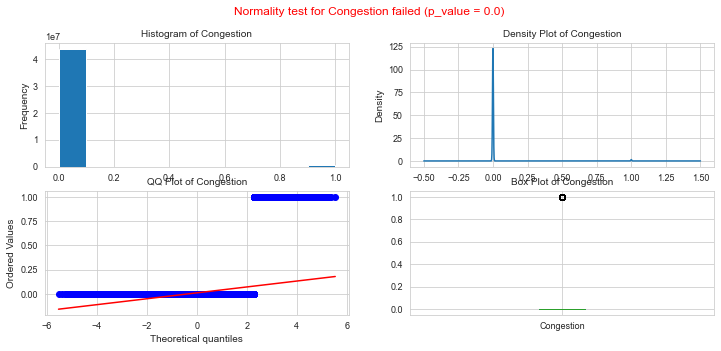

In [37]:
if Target in CategoricalColumns:
    w1_value = ''
    w1 = None  
    w1 = widgets.Dropdown(
        options=[Target],
        value=Target,
        description='Target Variable:',
    )
    i = interactive(TargetAnalytics.custom_barplot, df=fixed(df), col1=w1)
    hbox = widgets.HBox(i.children[:1])
    display(hbox)
    hbox.on_displayed(TargetAnalytics.custom_barplot(df=df, col1=w1.value))
else:
    w1_value = ''
    w1 = None
    w1 = widgets.Dropdown(
            options=[Target],
            value=Target,
            description='Target Variable:',
        )
    i = interactive(NumericAnalytics.custom_barplot, df=fixed(df), col1=w1)
    hbox = widgets.HBox(i.children)
    display(hbox)
    hbox.on_displayed(NumericAnalytics.custom_barplot(df=df, col1=w1.value))

### Explore individual numeric variables and test for normality 

In [38]:
CategoricalColumns = list(set(['LineID', 'Direction', 'TimeFrame', 'VehicleJourneyID', 'Operator', 'Congestion',  'Delay', 'BlockID', 'VehicleID', 'StopID', 'AtStop']))
NumericalColumns = list(set(list(df.select_dtypes([np.number]).columns)))


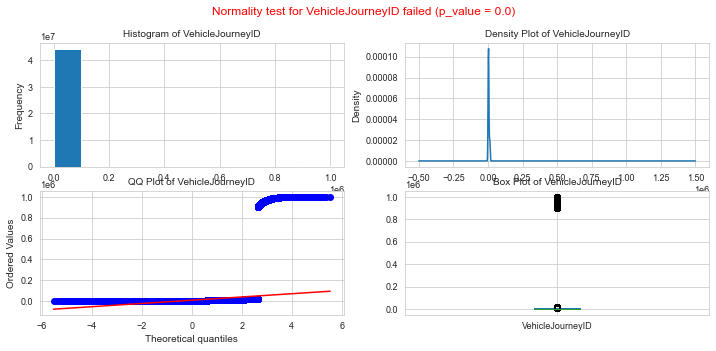

In [39]:
w1_value = ''
w1 = None
w1 = widgets.Dropdown(
        options=NumericalColumns,
        value=NumericalColumns[0],
        description='Numeric Variable:',
    )

i = interactive(NumericAnalytics.custom_barplot, df=fixed(df), col1=w1)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(NumericAnalytics.custom_barplot(df=df, col1=w1.value))

### Explore individual categorical variables (sorted by frequencies)

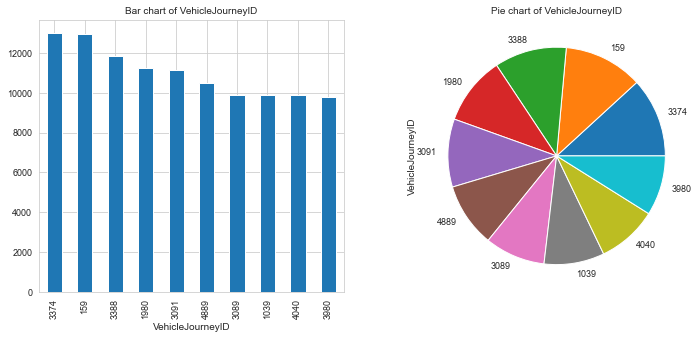

In [40]:
w1_value = ''
w1 = None

w1 = widgets.Dropdown(
    options = CategoricalColumns,
    value = CategoricalColumns[0],
    description = 'Categorical Variable:',
)


i = interactive(CategoricAnalytics.custom_barplot, df=fixed(df), col1=w1)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(CategoricAnalytics.custom_barplot(df=df, col1=w1.value))

## <a name="multiple variables"></a>Explore Interactions Between Variables
### <a name="rank variables"></a>Rank variables based on linear relationships with reference variable

MemoryError: Unable to allocate 6.02 TiB for an array with shape (44453044, 18614) and data type float64

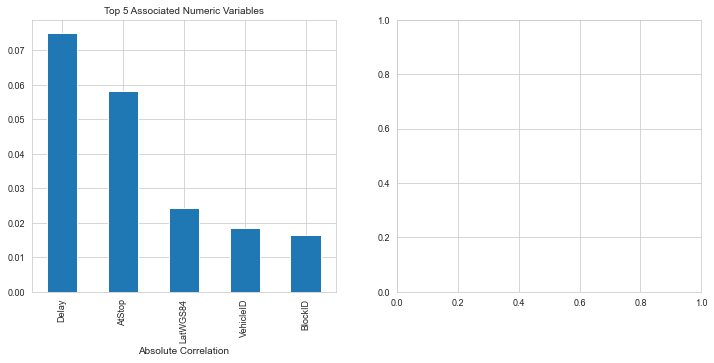

In [41]:
cols_list = [Target] + NumericalColumns + CategoricalColumns
cols_list = list(OrderedDict.fromkeys(cols_list)) 
w1 = widgets.Dropdown(    
    options=cols_list,
    value=cols_list[0],
    description='Ref Var:'
)
w2 = ipywidgets.Text(value="5", description='Top Num Vars:')
w3 = ipywidgets.Text(value="5", description='Top Cat Vars:')
i = interactive(InteractionAnalytics.rank_associations, df=fixed(df),conf_dict=fixed(cols_list), col1=w1, col2=w2, col3=w3)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.rank_associations(df=df, conf_dict=cols_list, col1=w1.value, col2=w2.value, col3=w3.value))

### <a name="two categorical"></a>Explore interactions between categorical variables

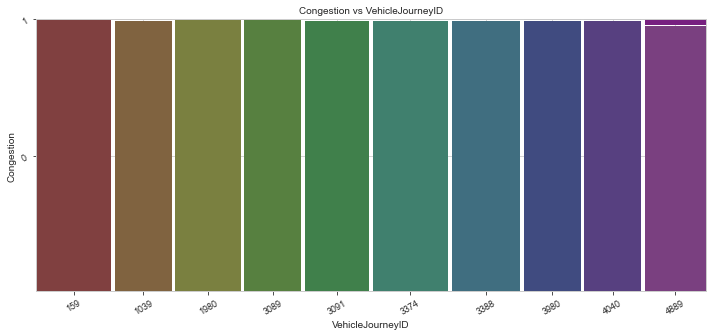

In [42]:
w1, w2 = None, None

if Target in CategoricalColumns:
    cols_list = [Target] + CategoricalColumns 
    cols_list = list(OrderedDict.fromkeys(cols_list)) 
else:
    cols_list = CategoricalColumns
    
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Categorical Var 1:'
)
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[1],
    description='Categorical Var 2:'
)

i = interactive(InteractionAnalytics.categorical_relations, df=fixed(df), col1=w1, col2=w2)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.categorical_relations(df=df, col1=w1.value, col2=w2.value))

### <a name="two numerical"></a>Explore interactions between numerical variables

In [ ]:
w1, w2 = None, None

if Target in NumericalColumns:
    cols_list = [Target] + NumericalColumns 
    cols_list = list(OrderedDict.fromkeys(cols_list)) 
else:
    cols_list = NumericalColumns
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Numerical Var 1:'
)
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[1],
    description='Numerical Var 2:'
)
i = interactive(InteractionAnalytics.numerical_relations, df=fixed(df), col1=w1, col2=w2)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.numerical_relations(df, col1=w1.value, col2=w2.value))

### Explore correlation matrix between numerical variables

In [ ]:
w1 = None
w1 = widgets.Dropdown(
    options=['pearson','kendall','spearman'],
    value='pearson',
    description='Correlation Method:'
)
i = interactive(InteractionAnalytics.numerical_correlation, df=fixed(df), conf_dict=fixed(cols_list), col1=w1)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.numerical_correlation(df, conf_dict=cols_list, col1=w1.value))

### <a name="numerical and categorical"></a>Explore interactions between numerical and categorical variables

In [ ]:
w1, w2 = None, None

if Target in NumericalColumns:
    cols_list = [Target] + NumericalColumns #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = NumericalColumns
    
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Numerical Variable:'
)

if Target in CategoricalColumns:
    cols_list = [Target] + CategoricalColumns #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = CategoricalColumns
    
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Categorical Variable:'
)
i = interactive(InteractionAnalytics.nc_relation, df=fixed(df),conf_dict=fixed(cols_list), col1=w1, col2=w2, col3=fixed(w3))
hbox = widgets.HBox(i.children)
display( hbox )
hbox.on_displayed(InteractionAnalytics.nc_relation(df, cols_list, col1=w1.value, col2=w2.value))

### <a name="two numerical and categorical"></a>Explore interactions between two numerical variables and a categorical variable

In [ ]:
w1, w2, w3 = None, None, None

if Target in NumericalColumns:
    cols_list = [Target] + NumericalColumns 
    cols_list = list(OrderedDict.fromkeys(cols_list)) 
else:
    cols_list = NumericalColumns
    
w1 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[0],
    description = 'Numerical Var 1:'
)
w2 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[1],
    description = 'Numerical Var 2:'
)

if Target in CategoricalColumns:
    cols_list = [Target] + CategoricalColumns
    cols_list = list(OrderedDict.fromkeys(cols_list)) 
else:
    cols_list = CategoricalColumns
    
w3 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[0],
    description = 'Legend Cat Var:'
)
i = interactive(InteractionAnalytics.nnc_relation, df=fixed(df),conf_dict=fixed(cols_list), col1=w1, col2=w2, col3=w3)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.nnc_relation(df, cols_list, col1=w1.value,col2=w2.value, col3=w3.value))

## <a name="pca"></a>Visualize numerical data by projecting to principal component spaces

### Project data to 2-D principal component space 

In [ ]:
num_numeric = len(NumericalColumns)
if  num_numeric > 3:
    
    w1, w2, w3 = None, None, None
    if Target in CategoricalColumns:
        cols_list = [Target] + CategoricalColumns 
        cols_list = list(OrderedDict.fromkeys(cols_list)) 
    else:
        cols_list = CategoricalColumns
    w1 = widgets.Dropdown(
        options = cols_list,
        value = cols_list[0],
        description = 'Legend Variable:',
        width = 10
    )
    w2 = widgets.Dropdown(
        options = [str(x) for x in np.arange(1,num_numeric+1)],
        value = '1',
        width = 1,
        description='PC at X-Axis:'
    )
    w3 = widgets.Dropdown(
        options = [str(x) for x in np.arange(1,num_numeric+1)],
        value = '2',
        description = 'PC at Y-Axis:'
    )
    i = interactive(InteractionAnalytics.numerical_pca, df=fixed(df),conf_dict=fixed(cols_list), col1=w1, col2=w2, col3=w3)
    hbox = widgets.HBox(i.children[:3])
    display(hbox)
    hbox.on_displayed(InteractionAnalytics.numerical_pca(df, conf_dict=cols_list, col1=w1.value, col2=w2.value, col3=w3.value))

### Project data to 3-D principal component space

In [ ]:
if len(NumericalColumns) > 3:
    if Target in CategoricalColumns:
        cols_list = [Target] + CategoricalColumns 
        cols_list = list(OrderedDict.fromkeys(cols_list)) 
    else:
        cols_list = CategoricalColumns
    w1, w2 = None, None
    w1 = widgets.Dropdown(
        options=cols_list,
        value=cols_list[0],
        description='Legend Variable:'
    )
    w2 = ipywidgets.IntSlider(min=-180, max=180, step=5, value=30, description='Angle')
    i = interactive(InteractionAnalytics.pca_3d, df=fixed(df), conf_dict=fixed(cols_list),col1=w1, col2=w2, col3=fixed(w3))
    hbox=widgets.HBox(i.children[:2])
    display(hbox)
    hbox.on_displayed(InteractionAnalytics.pca_3d(df,cols_list,col1=w1.value,col2=w2.value))